### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [20]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [75]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [23]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [24]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [26]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [27]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')



Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00231, saving model to best_weights.h5
Epoch 2/50
1712/1712 [==============================] - 1s 356us/step - loss: 0.0017 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00231 to 0.00186, saving model to best_weights.h5
Epoch 3/50
1712/1712 [==============================] - 1s 352us/step - loss: 0.0013 - val_loss: 0.0020

Epoch 00003: val_loss did not improve from 0.00186
Epoch 4/50
1712/1712 [==============================] - 1s 352us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00186
Epoch 5/50
1712/1712 [==============================] - 1s 348us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00186
Epoch 6/50
1712/1712 [==============================] - 1s 378us/step - loss: 0.0010 - val_loss: 0.0018

1712/1712 [==============================] - 1s 365us/step - loss: 1.9754e-04 - val_loss: 7.6500e-04

Epoch 00043: val_loss did not improve from 0.00076
Epoch 44/50
1712/1712 [==============================] - 1s 364us/step - loss: 1.9744e-04 - val_loss: 7.6970e-04

Epoch 00044: val_loss did not improve from 0.00076
Epoch 45/50
1712/1712 [==============================] - 1s 370us/step - loss: 1.9759e-04 - val_loss: 7.6399e-04

Epoch 00045: val_loss did not improve from 0.00076
Epoch 46/50
1712/1712 [==============================] - 1s 349us/step - loss: 1.9777e-04 - val_loss: 7.4545e-04

Epoch 00046: val_loss improved from 0.00076 to 0.00075, saving model to best_weights.h5
Epoch 47/50
1712/1712 [==============================] - 1s 381us/step - loss: 2.0072e-04 - val_loss: 7.9277e-04

Epoch 00047: val_loss did not improve from 0.00075
Epoch 48/50
1712/1712 [==============================] - 1s 370us/step - loss: 1.9487e-04 - val_loss: 7.6073e-04

Epoch 00048: val_loss did not improv

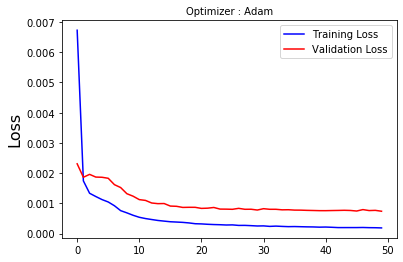

In [28]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [29]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [30]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

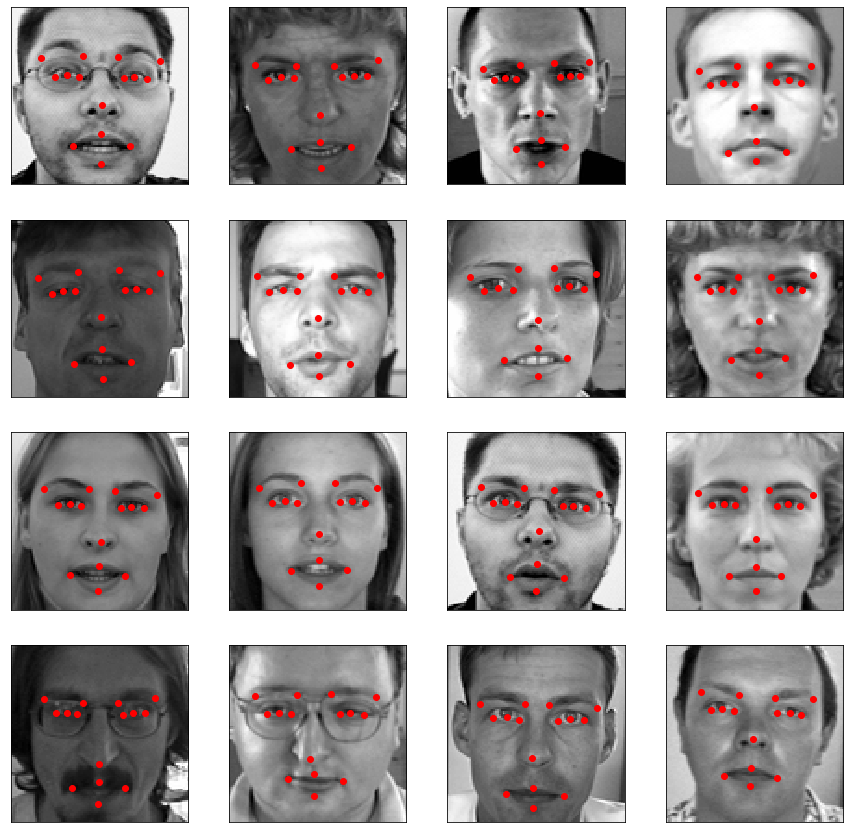

In [31]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [32]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
imgs_train.shape

(2140, 96, 96)

In [34]:
points_train.shape

(2140, 30)

In [67]:
# Your code
img_train_sample = imgs_train[0:1,::]
point_train_sample = points_train[0:1,:]

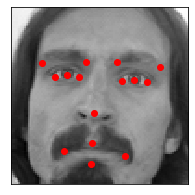

In [68]:
def show_figure(imgs, points):
    fig = plt.figure(figsize=(15,15))
    
    for i in range(imgs.shape[0]):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_keypoints(imgs[i], np.squeeze(points[i]))

show_figure(img_train_sample, point_train_sample)


-0.037285715
0.037285715


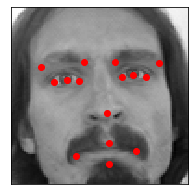

In [70]:
img_flip_sample = np.fliplr(img_train_sample[0].copy())
img_flip_sample = img_flip_sample.reshape(1, 96, 96)
point_flip_sample = point_train_sample[0].copy()
point_flip_sample[::2]*=-1
point_flip_sample = point_flip_sample.reshape(1, 30)
show_figure(img_flip_sample, point_flip_sample)

In [79]:
img_all_sample = imgs_train.copy()

for ind in range(points_train.shape[0]):
    tmp_img_flip = np.fliplr(imgs_train[ind].copy())
    tmp_img_flip = tmp_img_flip.reshape(1, 96, 96)
    img_all_sample = np.concatenate((img_all_sample, tmp_img_flip), axis=0)

img_all_sample.shape

(4280, 96, 96)

In [80]:
points_all_sample = points_train.copy()

for ind in range(points_train.shape[0]):
    tmp_point_flip = points_train[ind].copy()
    tmp_point_flip[::2]*=-1
    tmp_point_flip = tmp_point_flip.reshape(1, 30)
    points_all_sample = np.concatenate((points_all_sample, tmp_point_flip), axis=0)

points_all_sample.shape

(4280, 30)

In [81]:
# training the model
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

hist_flip_model = model.fit(img_all_sample.reshape(-1, 96, 96, 1), 
                       points_all_sample, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights_with_flip.h5')
# save the model
model.save('mode_with_flipl.h5')

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 2s 696us/step - loss: 0.0193 - val_loss: 0.0300

Epoch 00001: val_loss did not improve from 0.00074
Epoch 2/150
3424/3424 [==============================] - 1s 350us/step - loss: 0.0142 - val_loss: 0.0459

Epoch 00002: val_loss did not improve from 0.00074
Epoch 3/150
3424/3424 [==============================] - 1s 356us/step - loss: 0.0076 - val_loss: 0.0562

Epoch 00003: val_loss did not improve from 0.00074
Epoch 4/150
3424/3424 [==============================] - 1s 360us/step - loss: 0.0047 - val_loss: 0.0517

Epoch 00004: val_loss did not improve from 0.00074
Epoch 5/150
3424/3424 [==============================] - 1s 360us/step - loss: 0.0029 - val_loss: 0.0452

Epoch 00005: val_loss did not improve from 0.00074
Epoch 6/150
3424/3424 [==============================] - 1s 356us/step - loss: 0.0020 - val_loss: 0.0589

Epoch 00006: val_loss did not improve from 0.00074
Epoch 7/150

3424/3424 [==============================] - 1s 360us/step - loss: 3.4711e-04 - val_loss: 0.0516

Epoch 00051: val_loss did not improve from 0.00074
Epoch 52/150
3424/3424 [==============================] - 1s 361us/step - loss: 3.3665e-04 - val_loss: 0.0489

Epoch 00052: val_loss did not improve from 0.00074
Epoch 53/150
3424/3424 [==============================] - 1s 355us/step - loss: 3.3197e-04 - val_loss: 0.0508

Epoch 00053: val_loss did not improve from 0.00074
Epoch 54/150
3424/3424 [==============================] - 1s 360us/step - loss: 3.2280e-04 - val_loss: 0.0485

Epoch 00054: val_loss did not improve from 0.00074
Epoch 55/150
3424/3424 [==============================] - 1s 360us/step - loss: 3.1429e-04 - val_loss: 0.0490

Epoch 00055: val_loss did not improve from 0.00074
Epoch 56/150
3424/3424 [==============================] - 1s 361us/step - loss: 3.1676e-04 - val_loss: 0.0504

Epoch 00056: val_loss did not improve from 0.00074
Epoch 57/150
3424/3424 [=================


Epoch 00101: val_loss did not improve from 0.00074
Epoch 102/150
3424/3424 [==============================] - 1s 359us/step - loss: 2.9695e-04 - val_loss: 0.0479

Epoch 00102: val_loss did not improve from 0.00074
Epoch 103/150
3424/3424 [==============================] - 1s 370us/step - loss: 2.8743e-04 - val_loss: 0.0485

Epoch 00103: val_loss did not improve from 0.00074
Epoch 104/150
3424/3424 [==============================] - 1s 365us/step - loss: 2.8609e-04 - val_loss: 0.0487

Epoch 00104: val_loss did not improve from 0.00074
Epoch 105/150
3424/3424 [==============================] - 1s 357us/step - loss: 2.7702e-04 - val_loss: 0.0481

Epoch 00105: val_loss did not improve from 0.00074
Epoch 106/150
3424/3424 [==============================] - 1s 360us/step - loss: 2.7175e-04 - val_loss: 0.0485

Epoch 00106: val_loss did not improve from 0.00074
Epoch 107/150
3424/3424 [==============================] - 1s 374us/step - loss: 2.5903e-04 - val_loss: 0.0497

Epoch 00107: val_loss

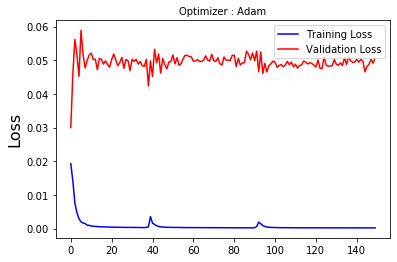

In [82]:
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_flip_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_flip_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

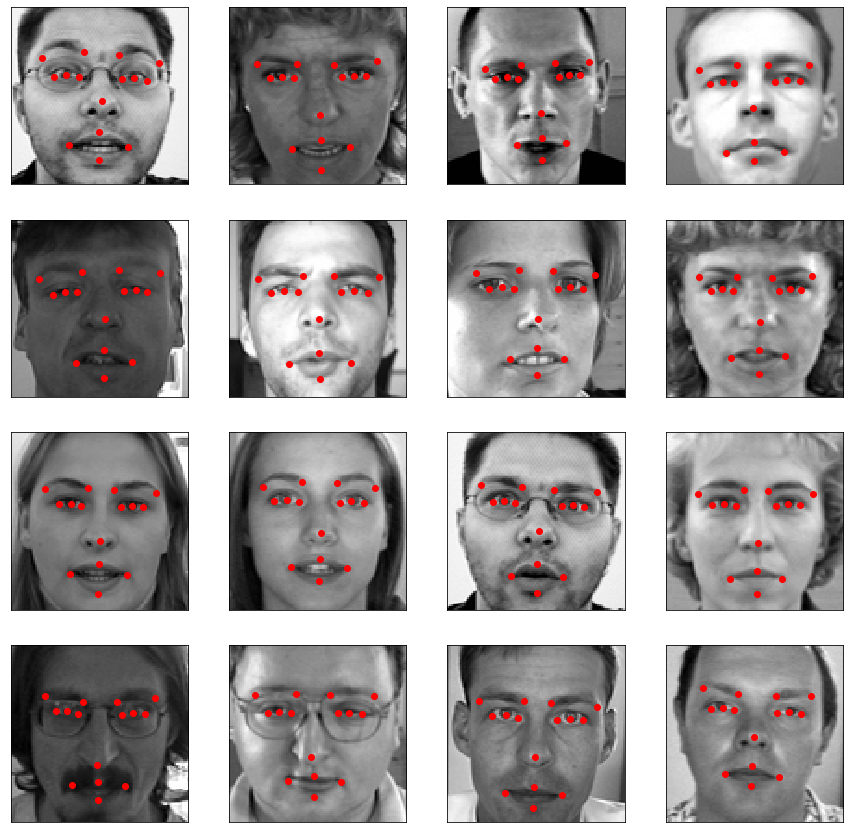

In [83]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))